In [ ]:
using LinearAlgebra
using LaTeXStrings
#using Plots
#gr()
using FFTW # for Fourier transforms
using Polynomials

<h2>Numerical</h2>

<h4>Bath egienmodes and dispersion</h4>

In [25]:
# params
N = 100 # photonic nodes
J = 1.0 # hopping strength

1.0

In [17]:
function hamiltonian(N,J,periodic=true)
    H = zeros(N,N)
    for n in 1:N-1
        H[n+1,n] = -J
        H[n,n+1] = -J
    end
    if periodic
        H[1,N] = -J
        H[N,1] = -J
    end
    return H
end

hamiltonian (generic function with 2 methods)

In [ ]:
# bath hamiltonian
H_bath = hamiltonian(N,J)

# diagonalize
evals, evecs = eigen(H_bath) # eigenvalues ordered by their energy, not necessarily their k value
k = -π .+ 2*π/N .* (0:N-1) # periodic bcs
#k = π/N .* (0:N-1) # fixed bcs
#scatter(k, evals, title="Dispersion relation fixed", xlab="|k|", ylab="E / J", legend=false)

100×100 Matrix{Float64}:
  0.0  -1.0   0.0   0.0   0.0   0.0  …   0.0   0.0   0.0   0.0   0.0  -1.0
 -1.0   0.0  -1.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0  -1.0   0.0  -1.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0  -1.0   0.0  -1.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0  -1.0   0.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0  -1.0   0.0  …   0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0  -1.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  ⋮                             ⋮    ⋱         ⋮                      
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.0   0.0   0.0   0.0   0.0   0.0      0.0   0.0   0.0   0.0   0.0   0.0
  0.

In [14]:
evecs

100×100 Matrix{Float64}:
 0.00437636   0.00874848  0.0131121   0.0174631  …   0.00874848  -0.00437636
 0.00874848   0.0174631   0.0261102   0.0346562     -0.0174631    0.00874848
 0.0131121    0.0261102   0.038881    0.0513136      0.0261102   -0.0131121
 0.0174631    0.0346562   0.0513136   0.0671776     -0.0346562    0.0174631
 0.0217972    0.0430682   0.0632996   0.082003       0.0430682   -0.0217972
 0.0261102    0.0513136   0.0747349   0.0955607  …  -0.0513136    0.0261102
 0.0303979    0.0593604   0.0855198   0.107641       0.0593604   -0.0303979
 0.0346562    0.0671776   0.0955607   0.118057      -0.0671776    0.0346562
 0.038881     0.0747349   0.10477     0.126648       0.0747349   -0.038881
 0.0430682    0.082003    0.113068    0.133281      -0.082003     0.0430682
 ⋮                                               ⋱               
 0.038881    -0.0747349   0.10477    -0.126648       0.0747349    0.038881
 0.0346562   -0.0671776   0.0955607  -0.118057      -0.0671776   -0.03465

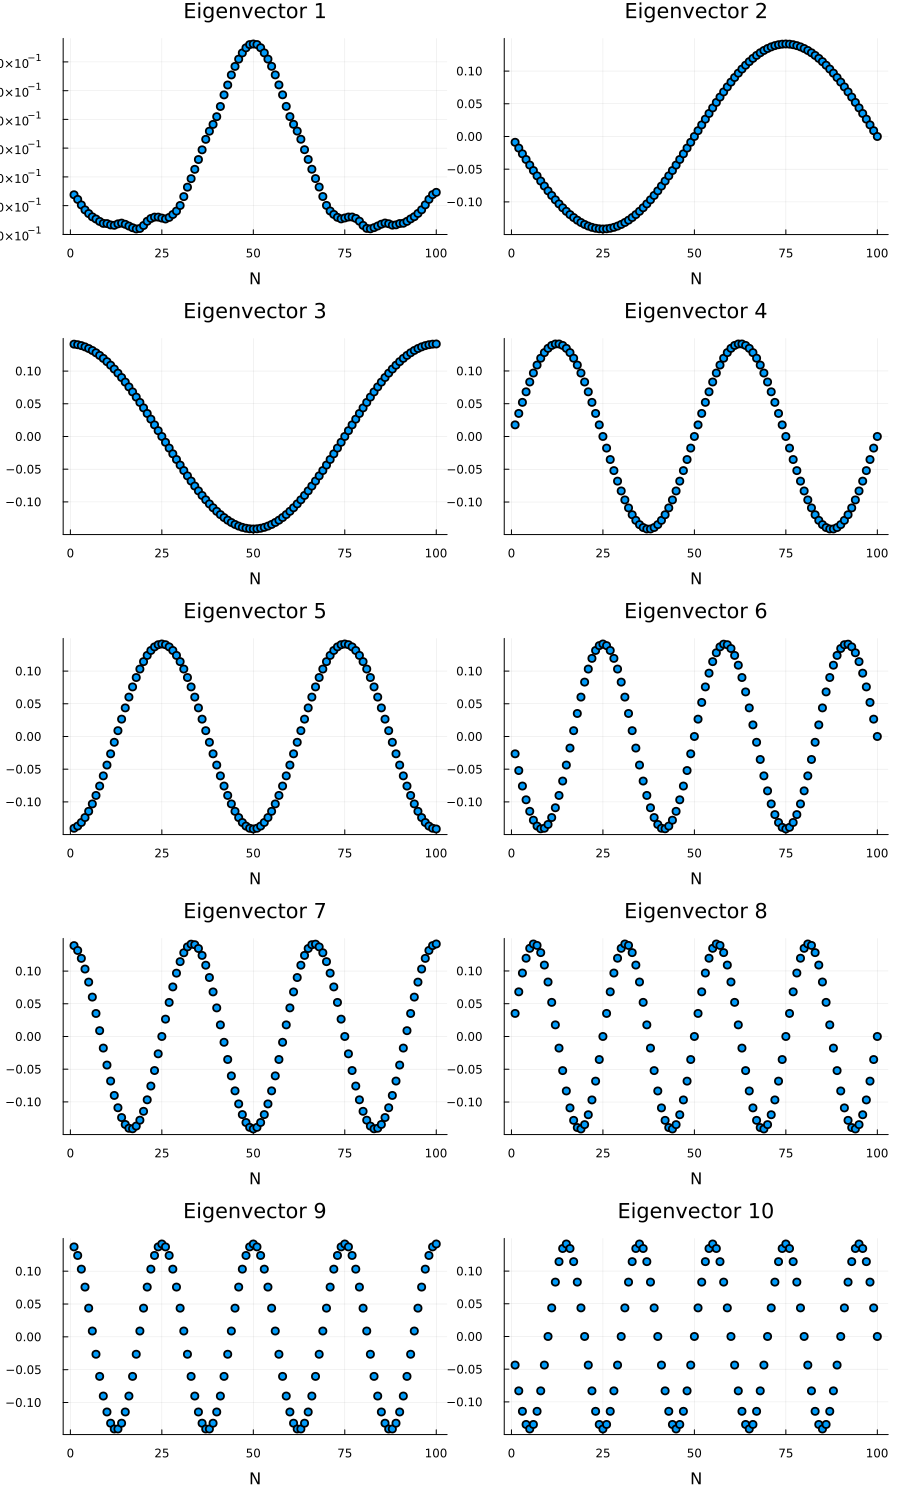

GKS: Possible loss of precision in routine SET_WINDOW


In [19]:
using Plots
# real space eigenvectors
fig = scatter(layout=(5, 2), size=(300*3, 300*5))

for i in 1:10
    scatter!(collect(1:N), evecs[:,i], title="Eigenvector $(i)", xlab="N", ylab="", legend=false, subplot=i)
end

display(fig)

In [20]:
# rotate each eigenspace to try to go from cosines and sines to exponentials
evecs_new = Complex.(evecs)
counter = 0
evals = round.(evals, digits=8)

for n in 1:2:100
    i,j... = findall(==(evals[n]), evals) # check for degenerate states and record their indeces
    if isempty(j) == true
        continue
    else
        counter += 1
        j = j[1]
        # old basis
        cos = evecs[:,i]
        sin = evecs[:,j]
        # new basis
        evecs_new[:,i] = cos .+ 1im.*sin
        evecs_new[:,j] = cos .- 1im.*sin
    end
end

In [23]:
evals,evecs = eigen([0 1; 0 0])
evals, evecs

([0.0, 0.0], [1.0 -1.0; 0.0 2.004168360008973e-292])

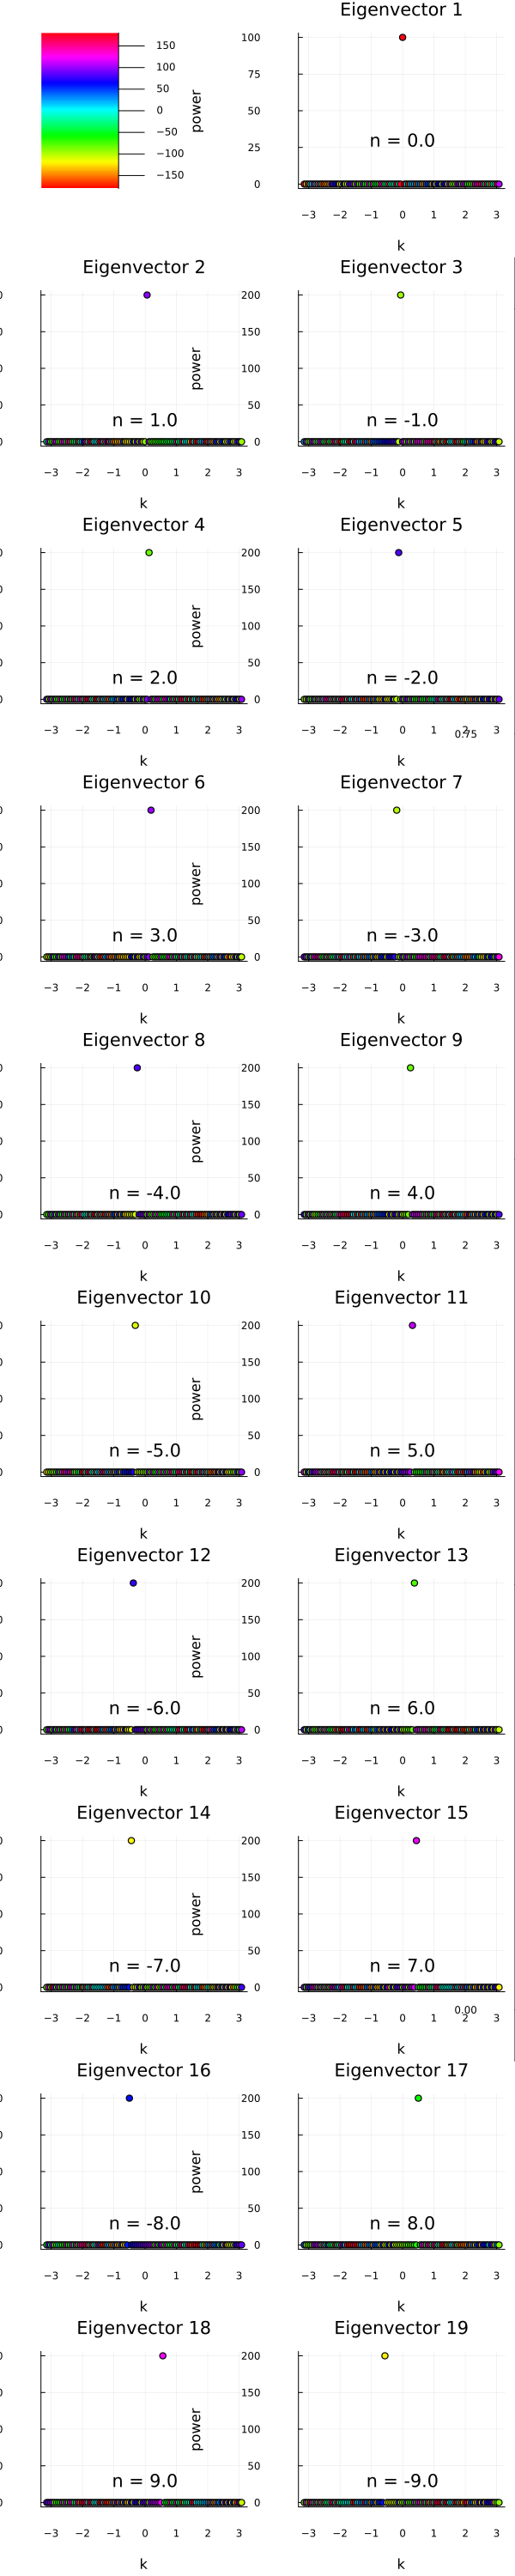

GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT
GKS: Rectangle definition is invalid in routine SET_VIEWPORT


In [21]:
# reciprocal space eigenvectors
fig = scatter(layout=(10, 2), size=(300*2, 300*10))
peaks = zeros(Int, N) # store positive peak index of each eigenvector
n = zeros(N) # multiple of fundamental freq (2π/N)

# perform FFT, note that this algorithm ASSUMES periodic bcs
for i in 2:20
    evecs_fft = fftshift(fft(evecs_new[:,i-1])) # match with negative freqs
    pwr_spectrum = abs2.(evecs_fft)
    phase = angle.(evecs_fft) .* 180 ./ π
    peaks_i = findall(>(40), pwr_spectrum) # indeces of all peaks
    peaks[i-1] = peaks_i[end]              
    n[i-1] = round(k[peaks[i-1]] * N / (2*π))
    annotate!(fig[i],(0,30, "n = $(n[i-1])"))
    if length(peaks_i) > 1
        phase_diff = mod(trunc(phase[peaks_i[end]] - phase[peaks_i[1]]), 360)
        scatter!(k, pwr_spectrum, marker_z = phase, subplot=i, title="Eigenvector $(i-1)", xlab="k", ylab="power", color=:hsv, colorbar= false, legend=false)
        annotate!(fig[i],(0,40, "∆φ = $(phase_diff)"))
    else
        scatter!(k, pwr_spectrum, marker_z = phase, subplot=i, title="Eigenvector $(i-1)", xlab="k", ylab="power", color=:hsv, colorbar= false, legend=false)
    end
end

scatter!([NaN], [NaN],marker_z = [0.0],color = :hsv,clim = (-180, 180),colorbar = true,subplot = 1,colorbar_titlefont = font(8))

#savefig("Rotated_Eigenvectors_spectrum.png")
display(fig)

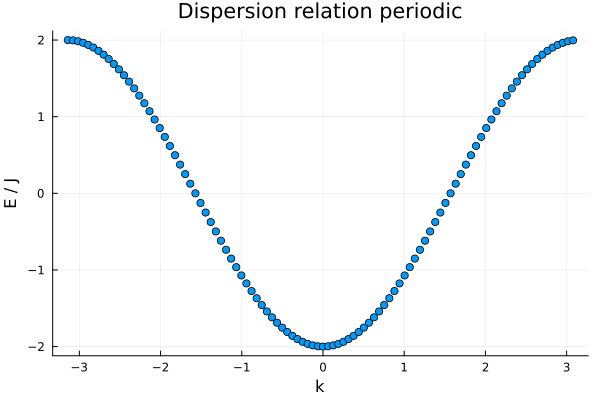

In [9]:
# order eigenvectors by increasing k
for i in 1:N
    evecs_fft = fftshift(fft(evecs_new[:,i])) # match with negative freqs
    pwr_spectrum = abs2.(evecs_fft)
    peaks_i = findall(>(30),pwr_spectrum) # indeces of all peaks
    peaks[i] = peaks_i[end]               # index of positive peak
    n[i] = k[peaks[i]] * N / (2*π)
end

sort = sortperm(n)             # index permutation that would sort n in ascending order
k_evals = (2*π / N) .* n[sort] # extracted ks in ascending order
evals = evals[sort]
scatter(k_evals, evals, title="Dispersion relation periodic", xlab="k", ylab="E / J", legend=false)
#savefig("Dispersion_ring.png")

<h4>Full Hamiltonian evolution</h4>

In [28]:
# params
δ = 0   # detuning
g = 1 # atom light coupling

1

In [ ]:
# 1 excitation subspace full hamiltonian in the reciprocal basis
# evals_bath = evals
H_full = zeros(N+1,N+1)
H_full[2:end,2:end] = Diagonal(evals_bath) # (periodic) bath part in k basis |k><k'|
H_full[1,1] = δ # |e><e|
H_full[1,2:end] = ones(N) .* g ./ √N # atom absorbs a photon from bath |e,vac><g,k|
H_full[2:end,1] = ones(N) .* g ./ √N # atom emits a photon into the bath |g,k><e,vac|

evals, evecs = eigen(H_full)
H_full

101×101 Matrix{Float64}:
 0.0   0.1   0.1       0.1       0.1      …  0.1      0.1      0.1      0.1
 0.1  -2.0   0.0       0.0       0.0         0.0      0.0      0.0      0.0
 0.1   0.0  -1.99605   0.0       0.0         0.0      0.0      0.0      0.0
 0.1   0.0   0.0      -1.99605   0.0         0.0      0.0      0.0      0.0
 0.1   0.0   0.0       0.0      -1.98423     0.0      0.0      0.0      0.0
 0.1   0.0   0.0       0.0       0.0      …  0.0      0.0      0.0      0.0
 0.1   0.0   0.0       0.0       0.0         0.0      0.0      0.0      0.0
 0.1   0.0   0.0       0.0       0.0         0.0      0.0      0.0      0.0
 0.1   0.0   0.0       0.0       0.0         0.0      0.0      0.0      0.0
 0.1   0.0   0.0       0.0       0.0         0.0      0.0      0.0      0.0
 ⋮                                        ⋱                             ⋮
 0.1   0.0   0.0       0.0       0.0         0.0      0.0      0.0      0.0
 0.1   0.0   0.0       0.0       0.0         0.0      0.0      0.

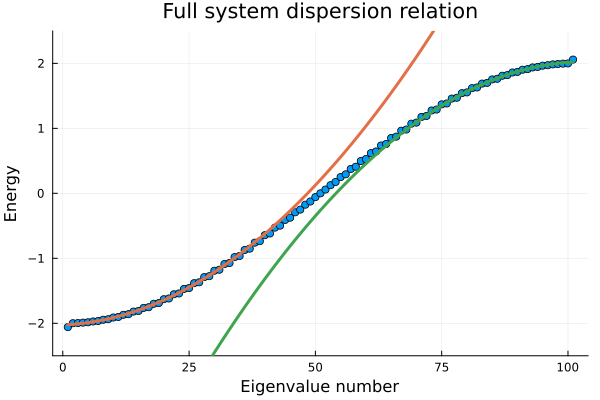

In [52]:
x = collect(1:length(evals))
p1_fit = fit(x[1:25], evals[1:25], 2)
p2_fit = fit(x[end-25:end], evals[end-25:end], 2)
scatter(1:length(evals) , evals, title="Full system dispersion relation", xlab="Eigenvalue number", ylab="Energy", legend=false)
plot!(x, p1_fit.(x), ylim=(-2.5,2.5), label="Parabola 1", lw=3)
plot!(x, p2_fit.(x), ylim=(-2.5,2.5), label="Parabola 2", lw=3)

In [30]:
ψ_0 = zeros(N+1)
ψ_0[1] = 1.0 # excited QE, empty bath

1.0

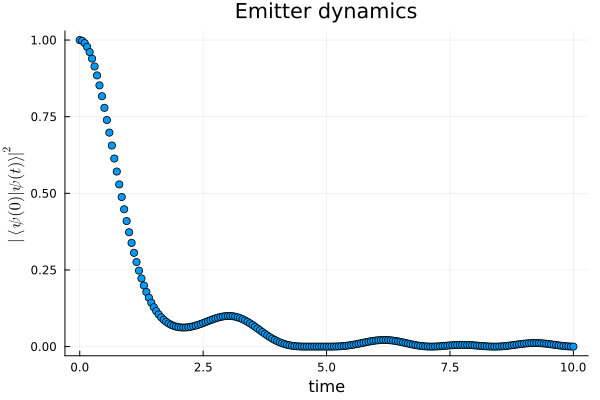

In [42]:
# evolution
times = collect(0:0.05:10)     # timestep
decays = zeros(length(times)) # vector to store probability of emitter still being excited

for (i,t) in enumerate(times)
    ψ_t = exp(-1im * H_full * t) * ψ_0  # Schrodinger's equation
    p_e = abs2(adjoint(ψ_0) * ψ_t) # Born's rule
    decays[i] = p_e
end

scatter(times,decays, title="Emitter dynamics", xlab="time", ylab=L"|\langle \psi(0) | \psi(t) \rangle |^2", legend=false)

<h2>Analytical</h2>

In [28]:
# density of states
function densityOfStates(E::Float64)
    return (2 * π * √(4 * J^2 - E^2))^(-1)
end


E = unique(round.(- 2 .* J .* cos.(k), digits = 8))
D_E = densityOfStates.(E)
integral = sum((D_E[1:end-1] .+ diff(D_E)./ 2) .* -diff(E)) # divergent integral
diff(E)

50-element Vector{Float64}:
 -0.003946540000000054
 -0.011824059999999914
 -0.01965490000000014
 -0.027408179999999893
 -0.035053290000000015
 -0.04256006000000001
 -0.04989887000000004
 -0.05704073999999992
 -0.06395751000000005
 -0.07062185999999993
  ⋮
 -0.06395751000000005
 -0.05704073999999992
 -0.04989887000000004
 -0.04256006000000001
 -0.035053290000000015
 -0.027408179999999893
 -0.01965490000000014
 -0.011824059999999914
 -0.003946540000000054

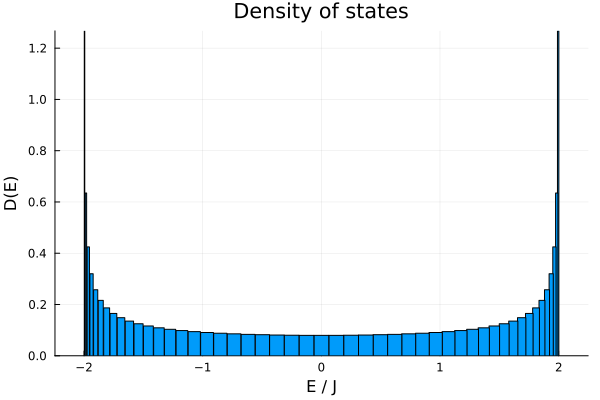

In [11]:
# plot
bar(E[1:end-1], D_E[1:end-1], bar_width=diff(E), title="Density of states", xlab="E / J", ylab="D(E)", legend=false)